In [1]:
from pathlib import Path
from flax.training import checkpoints
from configs import pretrain_causal as causal_config
import jax
from flax.core import frozen_dict
from model import UIL
from jax import numpy as jnp
from data import get_hf_image_dataset, image_transform
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from sklearn.decomposition import PCA

COLORS = list(mcolors.TABLEAU_COLORS)  # list of 100+ colors

In [2]:
config = causal_config.get_config()

In [3]:
# setup model and optimizer
rng = jax.random.PRNGKey(config.seed)
rng, init_rng = jax.random.split(rng)
uil_config = frozen_dict.FrozenDict(
    image_size=config.image_size,
    patch_size=config.patch_size,
    width=config.width,
    layers=config.layers,
    heads=config.heads,
    noise_std=config.noise_std,
    mask_ratio=config.mask_ratio,
    decoder_layers=config.decoder_layers,
    decoder_width=config.decoder_width,
    decoder_heads=config.decoder_heads,
    dropout_rate=config.dropout_rate,
    attn_dropout_rate=config.attn_dropout_rate,
    do_mae=config.mae,
    do_denoise=config.denoise,
    do_causal=config.causal,
)
mae_model = UIL(**uil_config, deterministic=True)

In [4]:
# get causal params
causal_ckpt_path = Path('checkpoints/pretrain/imagenet_causal_5e/checkpoints/')
causal_pretrained_params = checkpoints.restore_checkpoint(causal_ckpt_path, None, parallel=False)['params']
causal_fwd_params = {'params': causal_pretrained_params}

# get UIL params
uil_ckpt_path = Path('checkpoints/pretrain/imagenet_all_5e/checkpoints/')
uil_params = checkpoints.restore_checkpoint(uil_ckpt_path, None, parallel=False)['params']
uil_fwd_params = {'params': uil_params}

In [5]:
# load CIFAR-10 test dataset
cifar_test_loader = get_hf_image_dataset(
    data='cifar10',
    split='test',
    preprocess_fn=image_transform(config.image_size, is_train=False),
    batch_size=config.batch_size,
    num_workers=config.num_workers,
    image_key='img',
    label_key=config.label_key,
)
cifar_test_iter = iter(cifar_test_loader)
cifar_batch = next(cifar_test_iter)

In [6]:
# forward both models on a CIFAR-10 batch
cifar_causal_out = mae_model.apply(
    causal_fwd_params,
    cifar_batch['image'].permute(0, 2, 3, 1).numpy(),
    0,
    method=mae_model.encode_causal,
)
cifar_causal_latent_reps = cifar_causal_out[0][:, 0]

cifar_uil_out = mae_model.apply(
    uil_fwd_params,
    cifar_batch['image'].permute(0, 2, 3, 1).numpy(),
    0,
    method=mae_model.encode_causal,
)
cifar_uil_latent_reps = cifar_uil_out[0][:, 0]

In [7]:
# use t-SNE dim reduction
cifar_causal_emb = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate='auto',
).fit_transform(cifar_causal_latent_reps)
cifar_uil_emb = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate='auto',
).fit_transform(cifar_uil_latent_reps)

Text(0, 0.5, 'dim1')

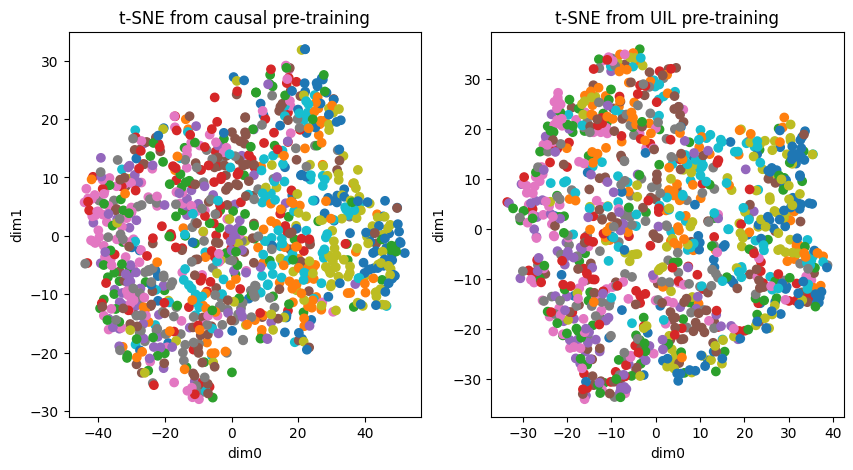

In [8]:
# plot UIL vs. causal t-SNE side-by-side
_, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].scatter(cifar_causal_emb[:, 0], cifar_causal_emb[:, 1], c=[COLORS[l.item()] for l in cifar_batch['label']])
axs[0].set_title('t-SNE from causal pre-training')
axs[0].set_xlabel('dim0')
axs[0].set_ylabel('dim1')

axs[1].scatter(cifar_uil_emb[:, 0], cifar_uil_emb[:, 1], c=[COLORS[l.item()] for l in cifar_batch['label']])
axs[1].set_title('t-SNE from UIL pre-training')
axs[1].set_xlabel('dim0')
axs[1].set_ylabel('dim1')

In [9]:
# load MNIST
mnist_test_loader = get_hf_image_dataset(
    data='mnist',
    split='test',
    preprocess_fn=image_transform(config.image_size, is_train=False),
    batch_size=config.batch_size,
    num_workers=config.num_workers,
    image_key='image',
    label_key=config.label_key,
)
mnist_test_iter = iter(mnist_test_loader)
mnist_batch = next(mnist_test_iter)

In [10]:
# forward causal & UIL models on MNIST
mnist_causal_out = mae_model.apply(
    causal_fwd_params,
    mnist_batch['image'].permute(0, 2, 3, 1).numpy(),
    0,
    method=mae_model.encode_causal,
)
mnist_causal_latent_reps = mnist_causal_out[0][:, 0]

mnist_uil_out = mae_model.apply(
    uil_fwd_params,
    mnist_batch['image'].permute(0, 2, 3, 1).numpy(),
    0,
    method=mae_model.encode_causal,
)
mnist_uil_latent_reps = mnist_uil_out[0][:, 0]

In [11]:
# use t-SNE dim reduction
mnist_causal_emb = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate='auto',
).fit_transform(mnist_causal_latent_reps)

mnist_uil_emb = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate='auto',
).fit_transform(mnist_uil_latent_reps)

Text(0, 0.5, 'dim1')

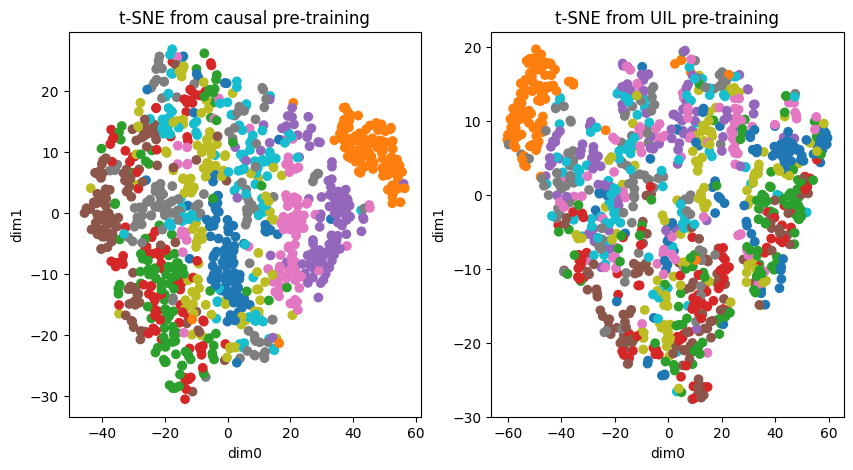

In [12]:
# plot UIL vs. causal t-SNE side-by-side
_, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].scatter(mnist_causal_emb[:, 0], mnist_causal_emb[:, 1], c=[COLORS[l.item()] for l in mnist_batch['label']])
axs[0].set_title('t-SNE from causal pre-training')
axs[0].set_xlabel('dim0')
axs[0].set_ylabel('dim1')

axs[1].scatter(mnist_uil_emb[:, 0], mnist_uil_emb[:, 1], c=[COLORS[l.item()] for l in mnist_batch['label']])
axs[1].set_title('t-SNE from UIL pre-training')
axs[1].set_xlabel('dim0')
axs[1].set_ylabel('dim1')